In [ ]:
!pip install seaborn

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

E:\anaconda3\envs\nlp2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gold_standards = {
    1: """Today we are celebrating the Dragon Boat Festival. In Chinese culture, this festival is a time to wish for safety, health, and good fortune in our lives. I also send these wishes to you, hoping you can share in the joy of the occasion.

Thank you for passing our message to the doctor in connection with his upcoming contract review. I already received confirmation of this from the professor a few days ago, and I am truly grateful for his continued support, especially regarding our Springer proceedings publication.""",
    
    2: """During our final discussion, I mentioned the new submission — the one we had been waiting for since last autumn. However, the updates were somewhat confusing, as they did not seem to include the full feedback from the reviewer or perhaps the editor.

Still, I believe the team — despite some delays and less communication in recent days — truly gave their best effort for both the paper and our collaboration. We should all be grateful for the acceptance and for everyone’s hard work, especially since the paper finally appeared on SpringerLink last week.

Could you also kindly remind me if the doctor still plans to edit the acknowledgments section before sending the final version? I didn’t see that part completed yet — or perhaps I overlooked it; if so, my apologies.

In any case, let’s make sure everything is finalized, stay safe, and celebrate this outcome together with strong coffee and new goals for the future."""
}

In [3]:
rule_df = pd.read_csv("rule_based_outputs.csv")

print("Rule-based:")
rule_df.head()

Rule-based:


,Text_ID,Original_Text,Rule_Based_Rewrite
0,1,"Today is our dragon boat festival, in our Chin...","Today is the Dragon Boat Festival, an importan..."
1,2,"During our final discuss, I told him about the...","During our last discussion, I informed him abo..."


In [4]:
pipe_df = pd.read_csv("pipeline_outputs.csv")

print("\nPipelines:\n")
pipe_df.head()


Pipelines:



,Text_ID,Original_Text,First_Model_Grammar,Second_Model_Summary,Third_Model_Grammar
0,1,"Today is our dragon boat festival, in our Chin...","Today is our dragon boat festival, in our Chin...","It is our dragon boat festival, in our Chines...","Today is our dragon boat festival, in our Chin..."
1,2,"During our final discuss, I told him about the...","During our final discuss, I told him about the...",The Springer link finally came finally last w...,"During our final discuss, I told him about the..."


In [5]:
df = pd.merge(rule_df, pipe_df, on="Text_ID", how="inner")

df.head()

,Text_ID,Original_Text_x,Rule_Based_Rewrite,Original_Text_y,First_Model_Grammar,Second_Model_Summary,Third_Model_Grammar
0,1,"Today is our dragon boat festival, in our Chin...","Today is the Dragon Boat Festival, an importan...","Today is our dragon boat festival, in our Chin...","Today is our dragon boat festival, in our Chin...","It is our dragon boat festival, in our Chines...","Today is our dragon boat festival, in our Chin..."
1,2,"During our final discuss, I told him about the...","During our last discussion, I informed him abo...","During our final discuss, I told him about the...","During our final discuss, I told him about the...",The Springer link finally came finally last w...,"During our final discuss, I told him about the..."


In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')

comparisons = []

for i, row in df.iterrows():
    original = row["Original_Text_x"]
    rule = row["Rule_Based_Rewrite"]
    first_m = row.get("First_Model_Grammar", "")
    second_m = row.get("Second_Model_Summary", "")
    third_m = row.get("Third_Model_Grammar", "")
    gold = gold_standards.get(row["Text_ID"], "")

    emb_original = model.encode([original])
    emb_rule = model.encode([rule])
    emb_first = model.encode([first_m])
    emb_second = model.encode([second_m])
    emb_third = model.encode([third_m])
    emb_gold = model.encode([gold])

    sims = {
        "Text_ID": row["Text_ID"],
        "Orig_vs_Rule": cosine_similarity(emb_original, emb_rule)[0][0],
        "Orig_vs_First": cosine_similarity(emb_original, emb_first)[0][0],
        "Orig_vs_Second": cosine_similarity(emb_original, emb_second)[0][0],
        "Orig_vs_Third": cosine_similarity(emb_original, emb_third)[0][0],

        "Rule_vs_First": cosine_similarity(emb_rule, emb_first)[0][0],
        "Rule_vs_Second": cosine_similarity(emb_rule, emb_second)[0][0],
        "Rule_vs_Third": cosine_similarity(emb_rule, emb_third)[0][0],

        "Gold_vs_Rule": cosine_similarity(emb_gold, emb_rule)[0][0],
        "Gold_vs_First": cosine_similarity(emb_gold, emb_first)[0][0],
        "Gold_vs_Second": cosine_similarity(emb_gold, emb_second)[0][0],
        "Gold_vs_Third": cosine_similarity(emb_gold, emb_third)[0][0],
        "Gold_vs_Orig": cosine_similarity(emb_gold, emb_original)[0][0]
    }
    comparisons.append(sims)

sims_df = pd.DataFrame(comparisons)
sims_df

,Text_ID,Orig_vs_Rule,Orig_vs_First,Orig_vs_Second,Orig_vs_Third,Rule_vs_First,Rule_vs_Second,Rule_vs_Third,Gold_vs_Rule,Gold_vs_First,Gold_vs_Second,Gold_vs_Third,Gold_vs_Orig
0,1,0.985884,0.997289,0.836562,0.993779,0.986431,0.846993,0.983883,0.933969,0.935001,0.854182,0.944220,0.924948
1,2,0.994018,0.995302,0.598943,0.995053,0.993472,0.595070,0.991171,0.927815,0.928759,0.457203,0.931976,0.925568


In [7]:
sims_df.to_csv("similarity_results.csv", index=False)
print("✅ Similarity results saved to similarity_results.csv")


✅ Similarity results saved to similarity_results.csv


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

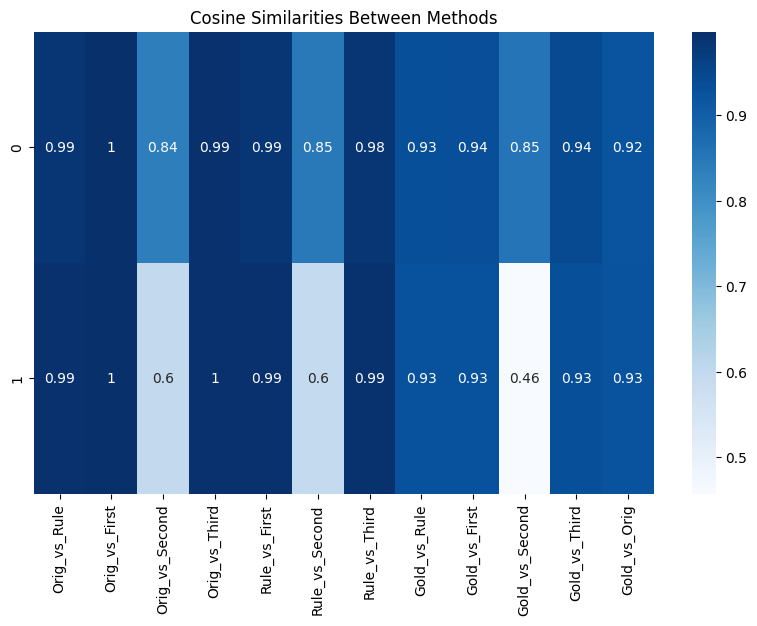

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(sims_df.drop(columns="Text_ID"), annot=True, cmap="Blues")
plt.title("Cosine Similarities Between Methods")
plt.show()